In [38]:
from IPython.display import display

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from sklearn.metrics import mean_squared_error

register_matplotlib_converters()

from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from numpy import log
from time import time
import seaborn as sns
sns.set_theme(style="whitegrid")
import itertools
import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = np.random.seed(0)

In [47]:
#date parser to formate the date in our desired format
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d %H:%M:%S')
#read data
df = pd.read_csv('data/metrics-7-5-24.csv')
df['time_stamp'] = pd.to_datetime(df['time_stamp'], utc=True)

# Remove UTC offset (+00:00)
df['time_stamp'] = df['time_stamp'].dt.tz_localize(None)

# Display the loaded DataFrame and its first few rows to verify
print(df)
print(df.head())


                              collection_id       vm_id             name     value          time_stamp
0      0a1e34c5-ce1a-491c-a3a4-b9f36582a7fb      K8s-cp   Percentage CPU  5.540875 2024-04-03 16:55:00
1      0a1e34c5-ce1a-491c-a3a4-b9f36582a7fb      K8s-cp   Percentage CPU  5.463167 2024-04-03 17:55:00
2      0a1e34c5-ce1a-491c-a3a4-b9f36582a7fb      K8s-cp   Percentage CPU  5.413875 2024-04-03 18:55:00
3      0a1e34c5-ce1a-491c-a3a4-b9f36582a7fb      K8s-cp   Percentage CPU  5.419500 2024-04-03 19:55:00
4      0a1e34c5-ce1a-491c-a3a4-b9f36582a7fb      K8s-cp   Percentage CPU  5.595208 2024-04-03 20:55:00
...                                     ...         ...              ...       ...                 ...
17723  57321b39-7d20-4c37-9341-f54072e01040  K8s-worker  Disk Read Bytes  0.000000 2024-07-03 19:00:00
17724  57321b39-7d20-4c37-9341-f54072e01040  K8s-worker  Disk Read Bytes  0.000000 2024-07-03 20:00:00
17725  57321b39-7d20-4c37-9341-f54072e01040  K8s-worker  Disk Read Bytes 

In [48]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # Assuming df is your DataFrame with 'time_stamp' and 'value' columns

# # Example of loading data from a CSV file
# # df = pd.read_csv('your_dataset.csv')

# # Group by hour and sum 'value'
# df['time_stamp'] = pd.to_datetime(df['time_stamp'])
# df['hour'] = df['time_stamp'].dt.hour
# df_hourly = df.groupby('hour')['value'].sum().reset_index()

# # Plotting
# plt.figure(figsize=(10, 6))
# plt.plot(df_hourly['hour'], df_hourly['value'], marker='o', linestyle='-')
# plt.title('Hourly Usage Trend')
# plt.xlabel('Hour of Day')
# plt.ylabel('Sum of Value')
# plt.xticks(range(24))  # Assuming 24 hours in a day
# plt.grid(True)
# plt.tight_layout()
# plt.show()


In [30]:
# df['date'] = pd.to_datetime(df['time_stamp']).dt.date

In [31]:
# df

In [49]:
df = df.groupby('time_stamp')['value'].sum()
df

time_stamp
2024-04-03 16:55:00    1.398339e+10
2024-04-03 17:55:00    1.373313e+10
2024-04-03 18:55:00    1.370295e+10
2024-04-03 19:55:00    1.375846e+10
2024-04-03 20:55:00    1.373806e+10
                           ...     
2024-07-03 19:00:00    1.261971e+10
2024-07-03 20:00:00    1.236849e+10
2024-07-03 21:00:00    1.242810e+10
2024-07-03 22:00:00    1.242019e+10
2024-07-03 23:00:00    1.247447e+10
Name: value, Length: 2192, dtype: float64

In [50]:
print(pd.infer_freq(df.index))

None


In [51]:
values = df.asfreq('D', method = 'ffill')
print(pd.infer_freq(values.index))

D


In [53]:
plt.figure(figsize=(14, 4))
plt.plot(df['time_stamp'], df['values'])  # Replace 'values' with your actual column name
plt.title('Daily Usage', fontsize=20)
plt.xlabel('Time Stamp', fontsize=16)
plt.ylabel('Usage', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

KeyError: 'time_stamp'

<Figure size 1400x400 with 0 Axes>

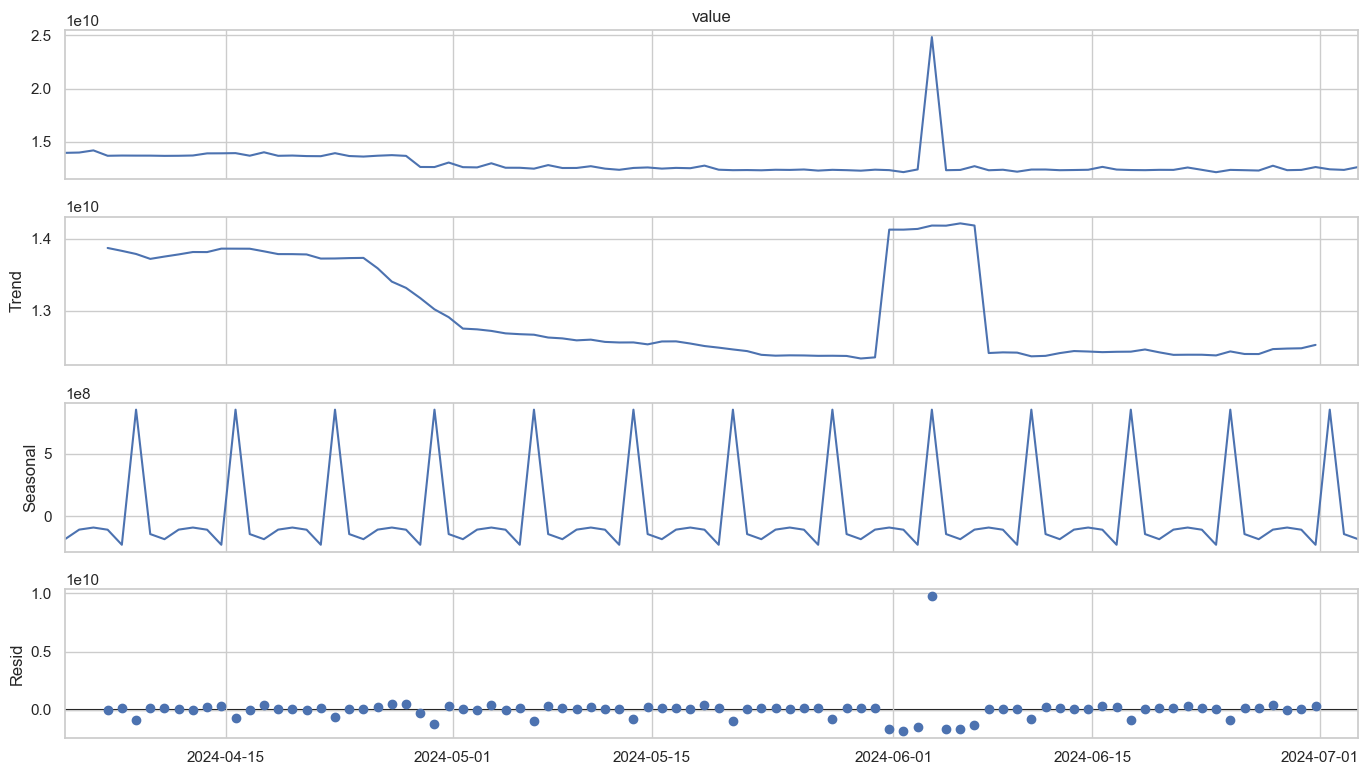

In [10]:
#STL (Seasonal Trend) Decomposition
plt.rc('figure',figsize=(14,8))
plt.rc('font',size=15)

result_stl = seasonal_decompose(values,model='additive')
fig = result_stl.plot()

In [28]:
dt_tickets = tickets.values - result_stl.trend
dt_tickets.dropna(inplace = True)

Text(0.5, 1.0, 'Tickets Sold detrended by subtracting the trend component')

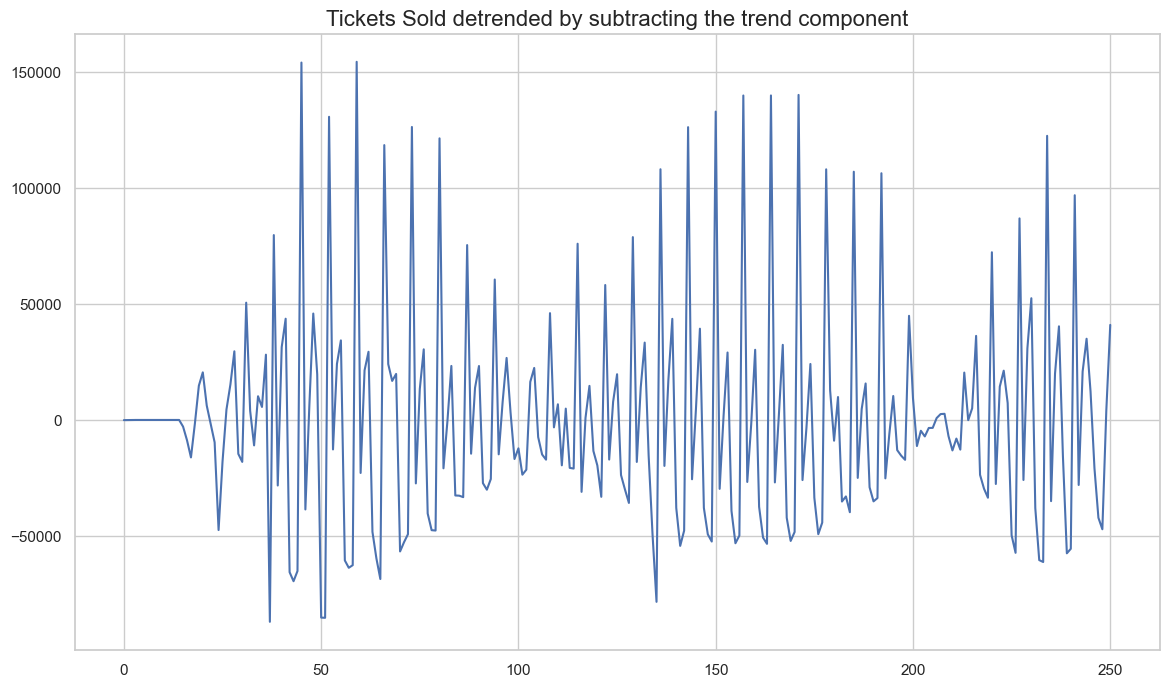

In [29]:
plt.plot(dt_tickets.values)
plt.title('Tickets Sold detrended by subtracting the trend component', fontsize=16)

In [116]:
# let's check for the stationaity in the series using Augmented Dickey Fuller
# ADF Test
result = adfuller(tickets, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -2.863744997033233
p-value: 0.04972931491782316


In [30]:
# let's check for the stationaity in the series using Augmented Dickey Fuller and KPSS tests
# ADF Test
result = adfuller(tickets, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')


# KPSS Test
result = kpss(tickets, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -2.863744997033233
p-value: 0.04972931491782316
Critial Values:
   1%, -3.457437824930831
Critial Values:
   5%, -2.873459364726563
Critial Values:
   10%, -2.573122099570008

KPSS Statistic: 0.164925
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


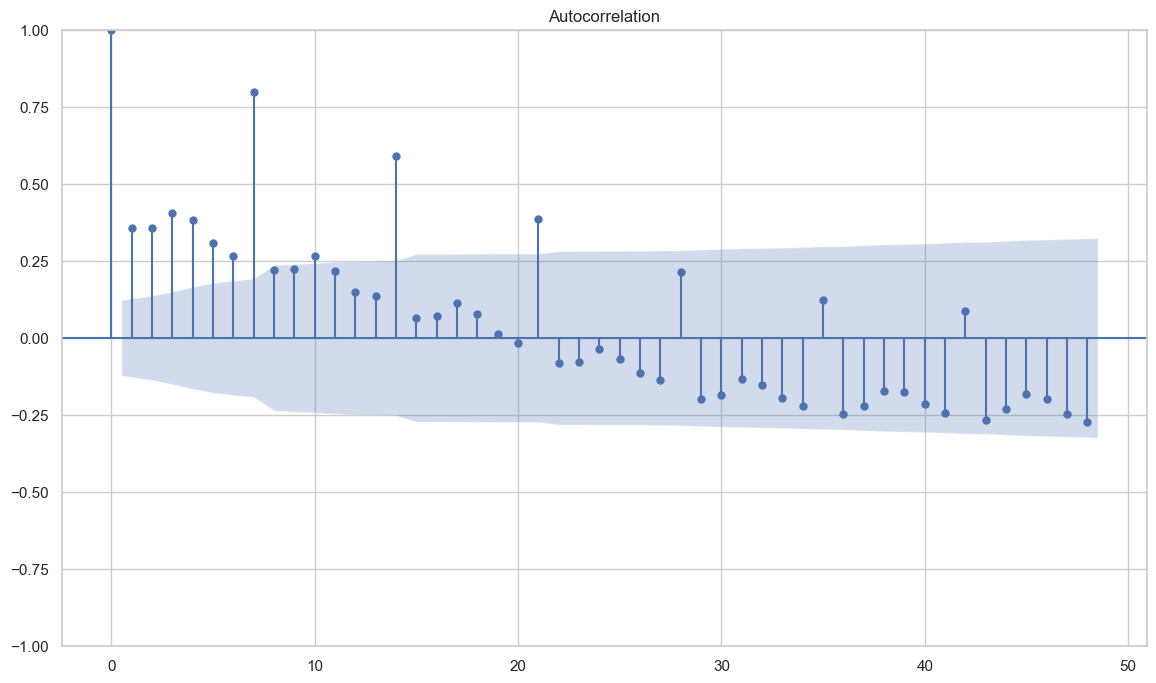

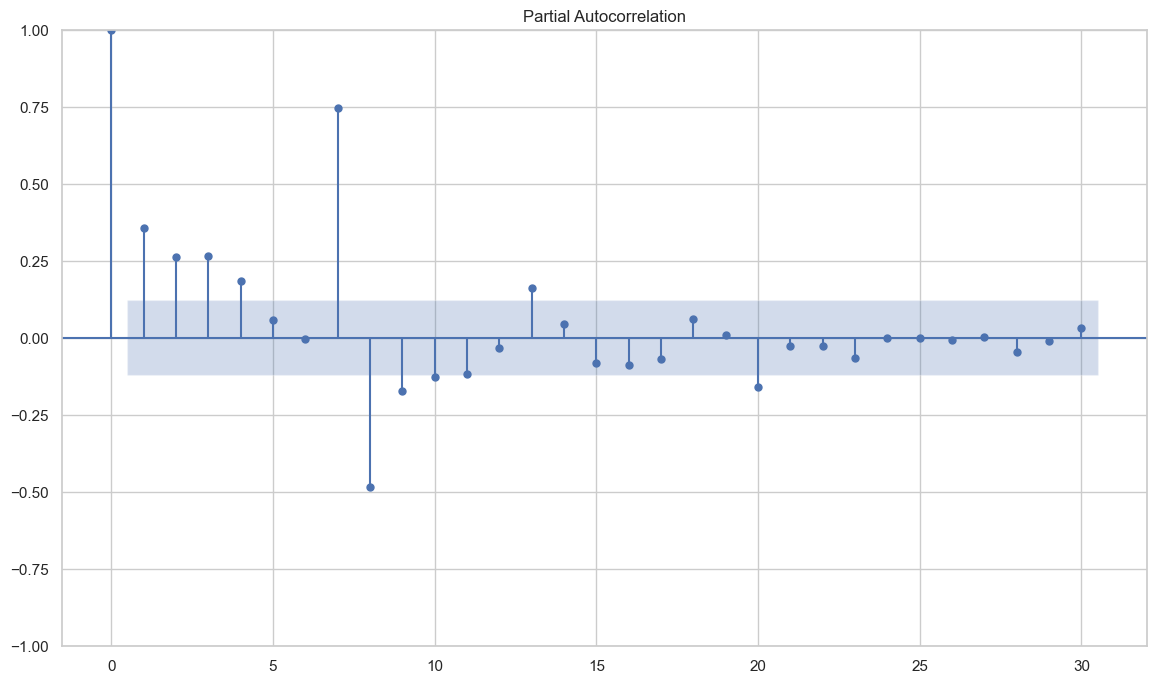

In [31]:
# Let’s look at ACF and PACF plots to get an idea for p and q values
plot_acf(tickets, lags=48);
plot_pacf(tickets, lags=30);

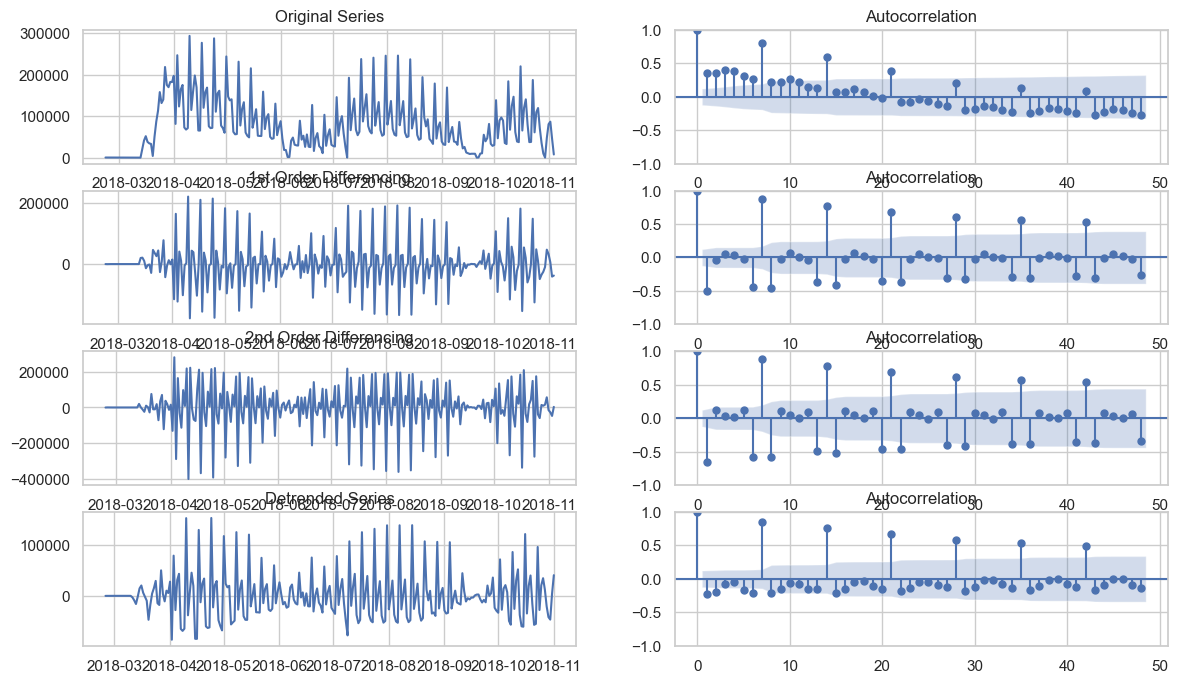

In [32]:
# Original Series
fig, axes = plt.subplots(4, 2)
axes[0, 0].plot(tickets); axes[0, 0].set_title('Original Series')
plot_acf(tickets, lags = 48, ax=axes[0, 1])

# 1st Differencing
tickets_1diff = tickets.diff()
tickets_1diff.dropna(inplace=True)
axes[1, 0].plot(tickets_1diff); axes[1, 0].set_title('1st Order Differencing')
plot_acf(tickets_1diff, lags = 48, ax=axes[1, 1])

# 2nd Differencing
tickets_2diff = tickets.diff().diff()
tickets_2diff.dropna(inplace=True)
axes[2, 0].plot(tickets_2diff); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(tickets_2diff, lags = 48, ax=axes[2, 1])

# Detrended Series
axes[3, 0].plot(dt_tickets); axes[3, 0].set_title('Detrended Series')
plot_acf(dt_tickets, lags = 48, ax=axes[3, 1])

plt.show()

In [33]:
# ADF Test
result = adfuller(tickets_1diff, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')


# KPSS Test
result = kpss(tickets_1diff, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -4.615743612521966
p-value: 0.00012080864742091214
Critial Values:
   1%, -3.457437824930831
Critial Values:
   5%, -2.873459364726563
Critial Values:
   10%, -2.573122099570008

KPSS Statistic: 0.186115
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


In [34]:
# ADF Test
result = adfuller(dt_tickets, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')


# KPSS Test
result = kpss(dt_tickets, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -7.592266212221313
p-value: 2.513179489398492e-11
Critial Values:
   1%, -3.458010773719797
Critial Values:
   5%, -2.8737103617125186
Critial Values:
   10%, -2.5732559963936206

KPSS Statistic: 0.390357
p-value: 0.081311
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


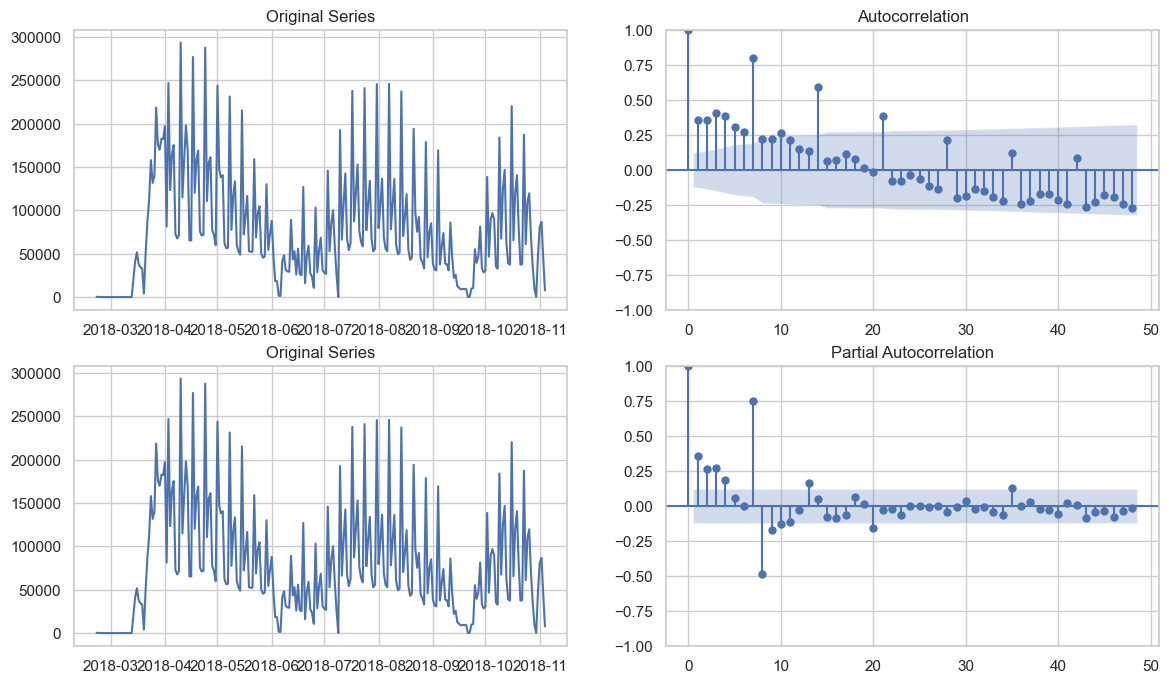

In [47]:
# Original Series
fig, axes = plt.subplots(2, 2)
axes[0, 0].plot(tickets); axes[0, 0].set_title('Original Series')
plot_acf(tickets, lags = 48, ax=axes[0, 1])

axes[1, 0].plot(tickets); axes[1, 0].set_title('Original Series')
plot_pacf(tickets, lags = 48, ax=axes[1, 1])

plt.show()

In [99]:
p = range(0, 4)
d = range(0, 1)
q = range(0, 5)
pdq = list(itertools.product(p, d, q))

In [73]:
print('Examples of parameter combinations for Seasonal ARIMA...')
print('ARIMA: {}'.format(pdq[1]))
print('ARIMA: {}'.format(pdq[2]))
print('ARIMA: {}'.format(pdq[3]))
print('ARIMA: {}'.format(pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
ARIMA: (0, 0, 1)
ARIMA: (0, 0, 2)
ARIMA: (0, 0, 3)
ARIMA: (0, 0, 4)


In [103]:
for param in pdq:
    try:
        mod = ARIMA(tickets, order=param)

        results = mod.fit()
        print('ARIMA{} - AIC:{}'.format(param, results.aic))
    except:
        continue

ARIMA(0, 0, 0) - AIC:7593.232576674349
ARIMA(0, 0, 1) - AIC:6402.06933584223
ARIMA(0, 0, 2) - AIC:6395.059294608991
ARIMA(0, 0, 3) - AIC:6337.352067090277
ARIMA(0, 0, 4) - AIC:6330.270634781341
ARIMA(1, 0, 0) - AIC:6389.907018823232
ARIMA(1, 0, 1) - AIC:6337.768618099035
ARIMA(1, 0, 2) - AIC:6336.46974543223
ARIMA(1, 0, 3) - AIC:6331.0936743925395
ARIMA(1, 0, 4) - AIC:6330.145607360117
ARIMA(2, 0, 0) - AIC:6373.163643029051
ARIMA(2, 0, 1) - AIC:6337.511667528543
ARIMA(2, 0, 2) - AIC:6325.288034451343
ARIMA(2, 0, 3) - AIC:6323.120835109731
ARIMA(2, 0, 4) - AIC:6320.434811474861
ARIMA(3, 0, 0) - AIC:6355.633898393744
ARIMA(3, 0, 1) - AIC:6336.4737651986725
ARIMA(3, 0, 2) - AIC:6322.884853083062
ARIMA(3, 0, 3) - AIC:6319.406354308729
ARIMA(3, 0, 4) - AIC:6288.943570686855


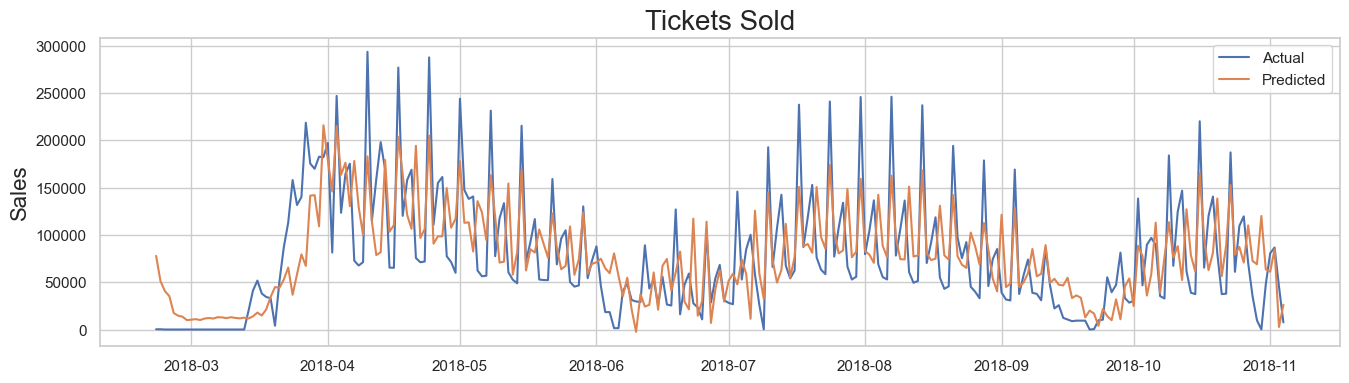

In [117]:
arima = ARIMA(tickets, order=(3,0,4))
predictions = arima.fit().predict()
plt.figure(figsize=(16,4))
plt.plot(tickets, label="Actual")
plt.plot(predictions, label="Predicted")
plt.title('Tickets Sold', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.legend()

In [42]:
train = tickets[:200]
test = tickets[200:]

In [104]:
ar_model = ARIMA(train, order=(3,0,4))
ar_fit = ar_model.fit()
ar_fc = ar_fit.forecast(steps=57)

In [105]:
ar_rsme = np.sqrt(mean_squared_error(test,ar_fc))
ar_rsme

50683.02051107291

In [106]:
model = auto_arima(tickets, start_p=0, start_q=0,
                          max_p=3, max_q=4,m=7,start_P=0,start_Q=0, 
                          max_P =3, max_Q =4,
                          seasonal=True,
                          d=0,D=0,trace=True,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=6423.120, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=6275.891, Time=0.40 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=6287.255, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=6653.660, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=6389.910, Time=0.04 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=6268.413, Time=0.67 sec
 ARIMA(1,0,0)(3,0,0)[7] intercept   : AIC=6262.901, Time=1.68 sec
 ARIMA(1,0,0)(3,0,1)[7] intercept   : AIC=inf, Time=2.56 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=inf, Time=1.85 sec
 ARIMA(0,0,0)(3,0,0)[7] intercept   : AIC=6333.016, Time=1.16 sec
 ARIMA(2,0,0)(3,0,0)[7] intercept   : AIC=6233.875, Time=2.23 sec
 ARIMA(2,0,0)(2,0,0)[7] intercept   : AIC=6236.276, Time=1.06 sec
 ARIMA(2,0,0)(3,0,1)[7] intercept   : AIC=inf, Time=2.77 sec
 ARIMA(2,0,0)(2,0,1)[7] intercept   : AIC=inf, Time=1.77 sec
 ARIMA(3,0,0)(3,0,0)[7] intercept   : AIC=6209.891, T

In [107]:
sarima = SARIMAX(tickets,
                order=(3,0,3),
                seasonal_order=(1,0,0,7))
predictions = sarima.fit().predict()

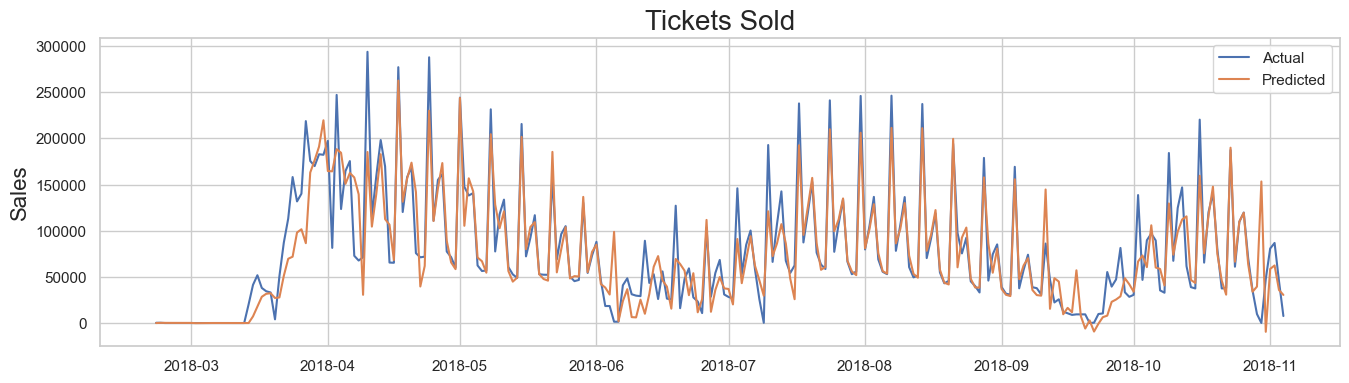

In [108]:
plt.figure(figsize=(16,4))
plt.plot(tickets, label="Actual")
plt.plot(predictions, label="Predicted")
plt.title('Tickets Sold', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.legend()

In [118]:
sr_model = SARIMAX(train,
                order=(3,0,3),
                seasonal_order=(1,0,0,7))
sr_fit = sr_model.fit()
sr_fc = sr_fit.forecast(steps=57)

In [110]:
sr_rmse = np.sqrt(mean_squared_error(test,sr_fc))
sr_rmse

58815.805788801976

In [111]:
print("ARIMA RMSE -> {}".format(ar_rsme))
print("SARIMAX RMSE -> {}".format(sr_rmse))

ARIMA RMSE -> 50683.02051107291
SARIMAX RMSE -> 58815.805788801976
